In [ ]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [ ]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [ ]:
def plot_image_and_mask(image, masks, ax=None):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0)
    
    if ax is None:
        plt.imshow(image_with_masks)
        plt.axis('off')
    else:
        ax.imshow(image_with_masks)
        
    

In [ ]:
from dataloaders.solar_dk_dataset import SolarDKDataset
from dataloaders.nl_dataset import CocoSegmentationDataset
import torchvision.transforms.v2 as transforms

solar_dk_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
coco_folder = "data/NL-Solar-Panel-Seg-1/train"

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(640, interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

solar_dk_dataset = SolarDKDataset(solar_dk_folder, transform=transform, normalize=True)
coco_dataset = CocoSegmentationDataset(coco_folder, transform=transform, normalize=True)


In [ ]:
# Convert mean and std to tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

mean_tensor = torch.tensor(mean).view(1, 3, 1, 1)
std_tensor = torch.tensor(std).view(1, 3, 1, 1)

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1.]),
])

full_dataset = solar_dk_dataset + coco_dataset

image, mask = coco_dataset[10]

print(image.shape, mask.shape)

plot_image_and_mask(inv_transform(image), mask)

### Load the dataset

In [ ]:
from torch.utils.data import DataLoader
from models.architectures import DeepLabModel

train_dataloader = DataLoader(full_dataset, batch_size=1, shuffle=True, num_workers=4)
model = DeepLabModel(num_classes=2)

### Train the model

In [ ]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [ ]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

In [ ]:

base_model = BaseModel(model, torch.nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.001))
image, mask = next(iter(train_dataloader))
image, mask = next(iter(train_dataloader))

model.eval()
output = base_model(image)# Turn mask into two channel mask
output.shape

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torch import nn

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(mode="multiclass")
        self.jaccard_loss = JaccardLoss(mode="multiclass")

    def forward(self, y_pred, y_true):
        cross_entropy_loss = self.cross_entropy(y_pred, y_true)
        
        # Convert the mask from 2 channels to 1 channel
        y_true = torch.argmax(y_true, dim=1)
        
        dice_loss = self.dice_loss(y_pred, y_true)
        jaccard_loss = self.jaccard_loss(y_pred, y_true)
        
        # print(f"Cross entropy loss: {cross_entropy_loss}")
        # print(f"Dice loss: {dice_loss}")
        # print(f"Jaccard loss: {jaccard_loss}")

        return cross_entropy_loss + 2 * dice_loss + 3 * jaccard_loss

In [ ]:
import torch.nn.functional as F
from segmentation_models_pytorch.metrics import iou_score, get_stats
from losses import AsymmetricUnifiedFocalLoss

loss_fn = AsymmetricUnifiedFocalLoss(weight=0.3, delta=0.25, gamma=2)
loss = loss_fn(output, mask)
loss.item()


In [ ]:
from torchmetrics.functional.classification import accuracy, precision, recall, f1_score, jaccard_index, dice
from torch import sigmoid

# mask = mask.argmax(dim=1)
print(mask.unique())
print(output.argmax(dim=1).unique())

metrics = {
    "jaccard_index": jaccard_index(output, mask, task="multiclass", num_classes=2),
    "accuracy": accuracy(output, mask,task="multiclass", num_classes=2),
    "precision": precision(output, mask,task="multiclass", num_classes=2),
    "recall": recall(output, mask,task="multiclass", num_classes=2),
    "f1_score": f1_score(output, mask,task="multiclass", num_classes=2),
    "dice": dice(output, mask.int())
}

metrics

NameError: name 'label' is not defined

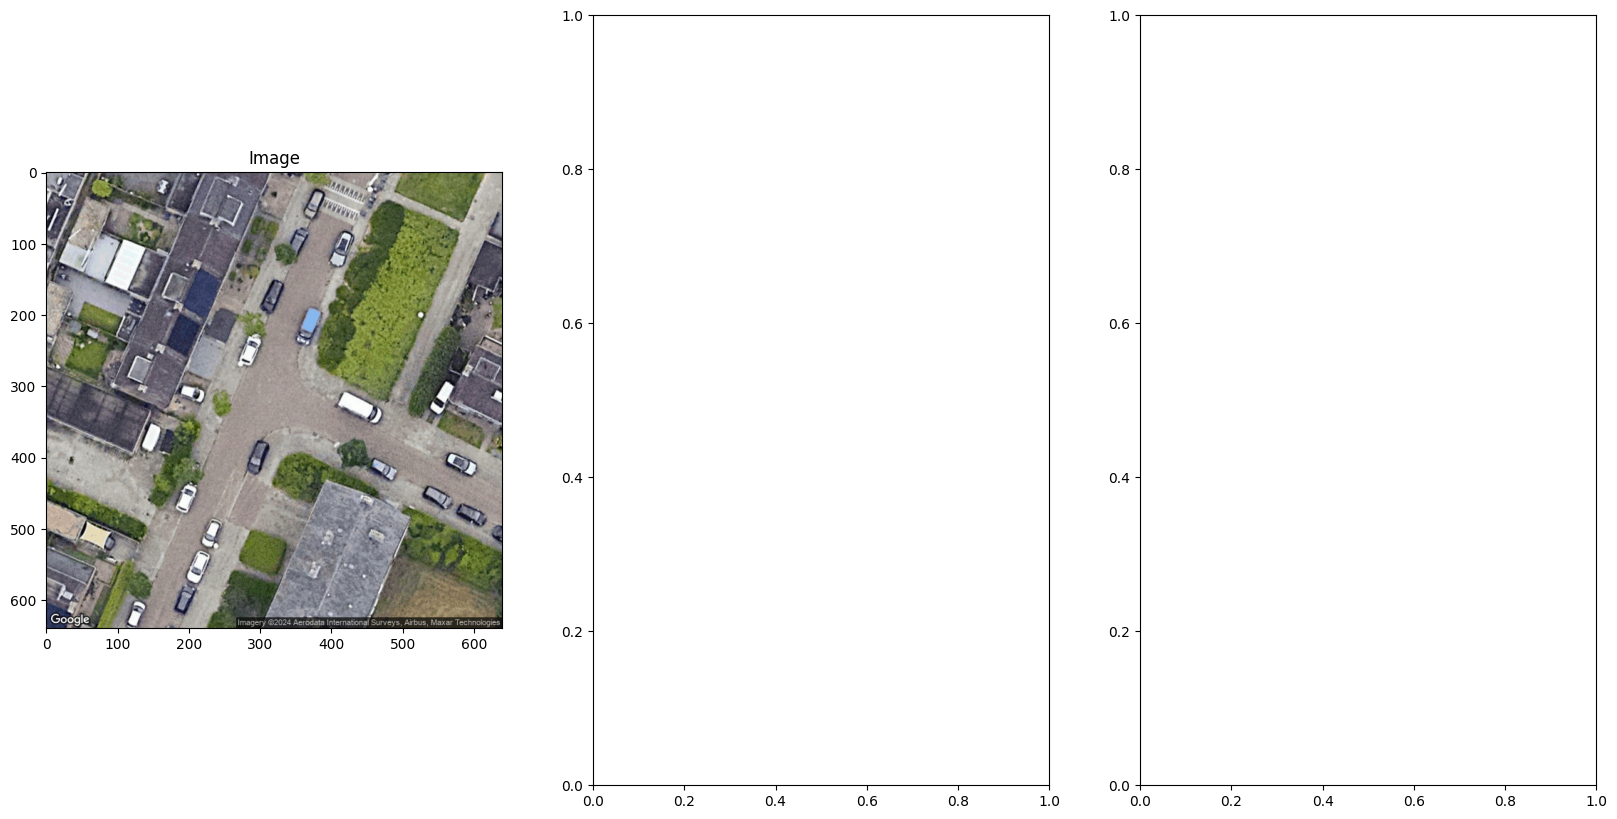

In [3]:
import torch
from models.base import BaseModel
import torchvision.transforms.v2 as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from PIL import Image

from losses import CombinedLoss
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

from dataloaders.solar_dk_dataset import SolarDKDataset
from dataloaders.nl_dataset import CocoSegmentationDataset
from dataloaders.germany_dataset import GermanyDataset

from torchmetrics.functional import jaccard_index, accuracy, precision, recall, f1_score, dice

from sklearn.metrics import jaccard_score, precision_score

class LossJaccard(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = JaccardLoss(mode="multiclass")

    def forward(self, y_hat, y):
        y = y.argmax(dim=1)
        return self.loss(y_hat, y)

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1.]),
])

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize((640, 640), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"
# test_dataset = SolarDKDataset(test_folder, total_samples=500)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# test_folder = "data/NL-Solar-Panel-Seg-1/test"
# test_dataset = CocoSegmentationDataset(test_folder)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# test_folder = "data/germany_dataset"
# test_dataset = GermanyDataset(test_folder)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


image = Image.open("imgs/eindhoven_satellite.png").convert("RGB")
image = transform(image).unsqueeze(0)

model = BaseModel.load_from_checkpoint("deeplabv3_0_94_iou_v2.ckpt")
# checkpoint = torch.load("lightning_logs/version_251115/checkpoints/last.ckpt", map_location=torch.device("cpu"))

task = "multiclass"
num_classes = 2

model.eval()
with torch.no_grad():
    # iterator = iter(test_loader)
    # image, label = next(iterator)
    output = model(image)
   
    image = inv_transform(image)
    # label = model.model.target(label)
    # # loss = loss_fn(output, label)
    
    # label = label.argmax(dim=1)
    
    # # print(f"Loss: {loss.item()}")          
    # print(f"Dice Score: {dice(output, label.int())}")
    # print(f"Jaccard Index: {jaccard_index(output, label, task=task, num_classes=num_classes, average='macro')}")
    # print(f"Precision: {precision(output, label, task=task, num_classes=  num_classes, average='macro')}")
    # print(f"Accuracy: {accuracy(output, label, task=task, num_classes=num_classes)}")
    # print(f"Recall: {recall(output, label, task=task, num_classes=num_classes)}")
    # print(f"F1 Score: {f1_score(output, label, task=task, num_classes=num_classes)}")
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
        
    ax[0].imshow(image[0].permute(1, 2, 0))
    ax[0].set_title("Image")
    
    # ax[1].imshow(label.squeeze(), cmap="gray")
    # ax[1].set_title("Label")     
    
    ax[2].imshow(output.argmax(dim=1).squeeze(), cmap="gray")
    ax[2].set_title("Prediction")
